In [1]:
from collections import defaultdict
import gymnasium as gym
import numpy as np

In [2]:
class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        lr,
        eps, eps_decay, min_eps,
        discount_factor = 0.95
    ):
        """
        Initialize RL agent
        - empty dict of state-action values (q_values)
        - lr
        - epsilon
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = lr
        self.discount_factor = discount_factor
        self.eps, self.eps_decay, self.min_eps = eps, eps_decay, min_eps
        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Return best action with probability (1 - eps)
        otherwise random action with probability eps to ensure exploration
        """
        if np.random.random() < self.eps:
            return self.env.action_space.sample() # random
        return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        future_q_values = (not terminated) * np.max(self.q_values[next_obs])
        temporal_diff = (
            reward
            + self.discount_factor * future_q_values
            - self.q_values[obs][action]
        )
        self.q_values[obs][action] += self.lr * temporal_diff
        self.training_error.append(temporal_diff)

    def decay_epsilon(self):
        self.eps = max(self.min_eps, self.eps - self.eps_decay)
        

In [3]:
lr = 5e-4
n_episodes = 10_000_000
eps = 1.0
eps_decay = eps / (n_episodes / 2) # reduce exploration over time
min_eps = 0.25

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
agent = BlackjackAgent(env, lr, eps, eps_decay, min_eps)


In [4]:
from tqdm import tqdm, trange
for episode in trange(n_episodes):
    obs, info = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)
        done = terminated or truncated
        obs = next_obs
    agent.decay_epsilon()

100%|███████████████████████████████████████████████| 10000000/10000000 [06:33<00:00, 25396.72it/s]


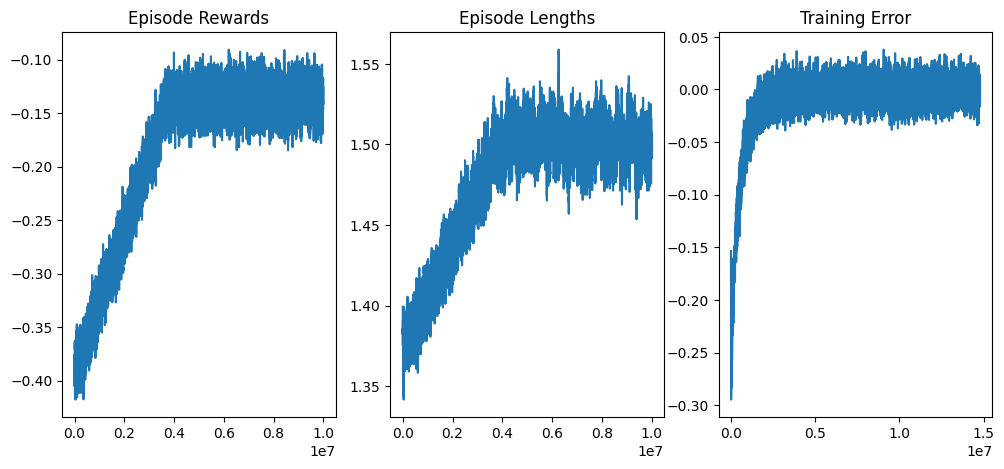

In [5]:
from matplotlib import pyplot as plt

def convolve(arr, window=5000, conv_mode="full"):
    return np.convolve(
        np.array(arr).flatten(),
        np.full(window, 1/window),
        mode=conv_mode,
    )

def plot(ax, arr, title):
    ax.set_title(title)
    ax.plot(range(len(arr)), arr)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 5))

reward_moving_avg = convolve(env.return_queue, conv_mode="valid")
plot(ax1, reward_moving_avg, title="Episode Rewards")

episode_len_moving_avg = convolve(env.length_queue, conv_mode="valid")
plot(ax2, episode_len_moving_avg, title="Episode Lengths")

trn_error_moving_avg = convolve(agent.training_error, conv_mode="same")
plot(ax3, trn_error_moving_avg, title="Training Error")

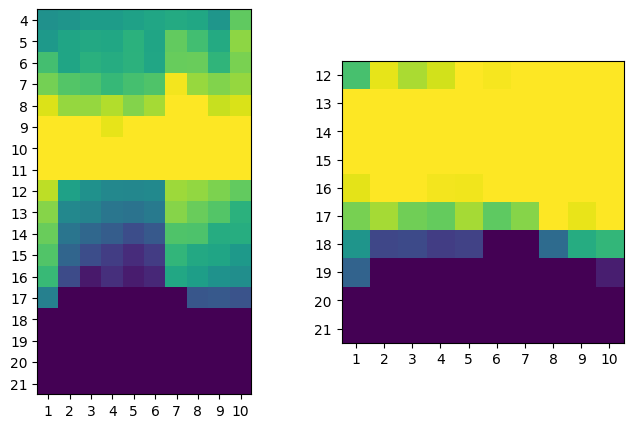

In [9]:
import matplotlib as mpl

# can you tell this is my code lol
def mk_vals(qs, nat):
    return {
        (i,j): np.sum(v * np.array([-1, 1])).item()
        for (i,j,n), v in qs.items()
        if n == nat
    }
    
qs = dict(sorted(filter(lambda x: x[0][0]<=21, dict(agent.q_values).items())))
na_qs = mk_vals(qs, nat=0)
a_qs = mk_vals(qs, nat=1)

na_mat = np.zeros([18, 10])
for (x,y), v in na_qs.items():
    assert x-4 >= 0 and x-4 <= 21
    na_mat[x-4, y-1] = v # 1. if v > 0. else 0.

a_mat = np.zeros([10, 10])
for (x,y), v in a_qs.items():
    assert x-12 >= 0 and x-12 <= 21
    a_mat[x-12, y-1] =  v # 1. if v > 0. else 0.

na_std = na_mat.std() / 2
a_std = a_mat.std() / 2

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 5))

ax1.set_yticks(range(18), range(4, 22))
ax1.set_xticks(range(10), range(1, 11))
ax2.set_yticks(range(10), range(12, 22))
ax2.set_xticks(range(10), range(1, 11))
ax1.imshow(
    na_mat,
    norm=mpl.colors.Normalize(vmin=-na_std, vmax=na_std, clip=True)
)
ax2.imshow(
    a_mat,
    norm=mpl.colors.Normalize(vmin=-a_std, vmax=a_std, clip=True)
)
plt.show()